# The Arena
### Pitting contenders against each other

In [1]:
from tqdm import tqdm
from domoku.policies.softadvice import MaxInfluencePolicyParams, MaxInfluencePolicy
from domoku.policies.maximal_criticality import MaxCriticalityPolicy
from domoku.policies import softadvice
from alphazero.gomoku_game import GomokuGame as Game
from alphazero.mcts import MCTS
from alphazero.gomoku_board import *

In [2]:
BOARD_SIZE=15
detector = MaxCriticalityPolicy(BOARD_SIZE)
the_game = Game(15, detector=detector, initial='H8')

2022-06-26 09:25:43.336602: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/wgiersche/.local/share/virtualenvs/DeepGomoku-cXtJ_EtM/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [3]:
def given_heuristic_brain():
    hard_policy = MaxCriticalityPolicy(board_size=BOARD_SIZE, overconfidence=.005)
    mi_params = MaxInfluencePolicyParams(
        board_size=BOARD_SIZE,
        sigma=.8,
        iota=3,
        radial_constr=[.0625, .125, .25, .5],
        radial_obstr=[-.0625, -.125, -.25, -.5]
    )
    policy = MaxInfluencePolicy(mi_params, criticality_model=hard_policy, pov=1)
    return softadvice.NeuralNetAdapter(policy)


def longest_trajectory(ts):
    depths = [v.level for v in ts.tree_nodes.values()]
    mx = max(depths)
    return [v for v in ts.tree_nodes.values() if v.level == mx][0]

---
# Current Status



It appears that the additional policy-driven action space reduction in ```def probable_actions(self, board: Board)``` is massively counterproductive. That is indeed plausible.

#### Use Threat-Search Policy Instead

The short-sighted policy can not see the future. By it's massive bias, it prevents the MC tree search from learning a meaningful UCB.
However, we need not worry too much. The heuristics is just meant to be a quickstarter for the actual NN to have a first baseline. We may also consider a generally more explorative version, determined by some higher temperature applied to the the choice of the candidate policy. Certainly this is going to be a critical hyper-parameter.

- Still, with num_simus = 400, the play does not appear to be future-looking, need clarification (alphago uses 1600)
- update_tree_view does not (always) work with two distinct mcts instances, since the parent lives in another tree.
- The state values displayed are always negative. Needs to be verified
- It's not clear how the mcts actually chooses the next move. We need to understand, what a good value for cpuct should be. It's the $u$ value:

$$
U(s, a) = Q(s, a) + c_{puct} P(s, a) \frac{\sqrt{\sum_b N(s, b)}}{1 + N(s, a)}
$$

In [4]:
brain_d = given_heuristic_brain()
mcts_d = MCTS(the_game, brain_d, cpuct=1.0, num_simulations=20, model_threshold=.3)

brain_c = given_heuristic_brain()
mcts_c = MCTS(the_game, brain_c, cpuct=1.0, num_simulations=400, model_threshold=.4)

board = the_game.get_initial_board()
Move=board.Stone

In [7]:
probs = mcts_c.get_action_prob(board, temperature=0)
move =Move(probs)
print(f"White: {move}")
board.act(move)

probs = mcts_d.get_action_prob(board, temperature=0)
move =Move(probs)
print(f"Black: {move}")
board.act(move)

board.plot()
#current_node = mcts_d.tree_nodes[board.get_string_representation()]
#for a, c in current_node.children.items():
#    print(Move(a), c.value, c.info[a]['u'])

White: K11
Black: K5
                                                     
15    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
14    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
13    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
12    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
11    .  .  .  .  .  .  .  .  .  .  O  .  .  .  .    
10    .  .  .  O  .  .  .  .  .  .  .  .  .  .  .    
 9    .  .  .  .  .  O  .  .  X  .  .  .  .  .  .    
 8    .  .  .  .  .  .  .  X  .  .  .  .  .  .  .    
 7    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 6    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 5    .  .  .  .  .  .  .  .  X  . [X] .  .  .  .    
 4    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 3    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 2    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
 1    .  .  .  .  .  .  .  .  .  .  .  .  .  .  .    
                                                     
      A  B  C  D  E  F  G  H  I  J  K  L  M  N  O


The values are always negative, which is not really easy to understand

In [8]:
Move(mcts_c.get_action_prob(board, temperature=0))

I7

In [9]:
board.undo()

H8 F9 I5 D10 I9 K11

In [10]:
[Move(int(a)) for a in mcts_c.probable_actions(board)]

[H9,
 J9,
 I8,
 J8,
 K8,
 G7,
 H7,
 I7,
 J7,
 K7,
 F6,
 G6,
 H6,
 I6,
 J6,
 K6,
 G5,
 H5,
 J5,
 K5,
 H4,
 I4,
 J4]

In [11]:
pi, _ = mcts_c.nnet.predict(board.canonical_representation())

In [12]:
print((pi.reshape([15, 15])*100).astype(int))

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 2 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 3 3 2 1 0 0 0]
 [0 0 0 0 0 0 2 3 3 3 2 1 0 0 0]
 [0 0 0 0 0 2 2 3 3 3 2 1 0 0 0]
 [0 0 0 0 0 1 2 2 0 2 2 1 0 0 0]
 [0 0 0 0 0 1 1 1 1 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [13]:
mcts_c.tree_nodes[board.get_string_representation()]

KeyError: '-2734968144196659472'

In [ ]:
board.print_pi()

In [64]:
from domoku.tools import GomokuTools as Gt
stones = Gt.string_to_stones("".join([str(s) for s in board.stones]))

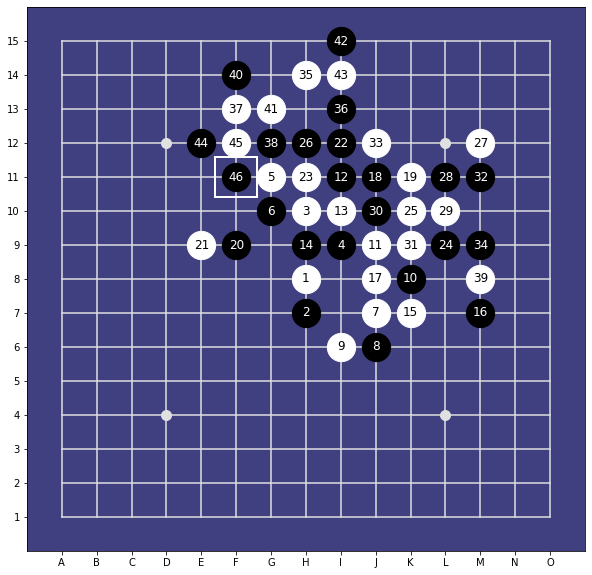

In [68]:
from domoku.board import GomokuBoard as LegacyBoard
legacy_board = LegacyBoard(n=15, disp_width=10, stones=stones)
legacy_board.display()

In [2]:
class Player:
    def __init__(self, mcts: MCTS, temperature):
        self.mcts = mcts
        self.temperature = temperature

    def play(self, board: Board):
       pass

In [3]:
class Arena:
    def __init__(self, game: Game):
        self.game = game
        pass

    def play_game(self, black: Player, white: Player, verbose: bool):
        pass

    def play_games(self, player1: Player, player2: Player, num_games, verbose=False):
        """
        Plays num games in which player1 starts num/2 games and player2 starts
        num/2 games.

        Returns:
            one_won: games won by player1
            two_won: games won by player2
            draws:  games won by nobody
        """

        num = int(num_games / 2)
        one_won = 0
        two_won = 0
        n_draws = 0
        for _ in tqdm(range(num), desc="Arena.play_games (1)"):
            game_result = self.play_game(black=player1, white=player2, verbose=verbose)
            if game_result == 1:
                one_won += 1
            elif game_result == -1:
                two_won += 1
            else:
                n_draws += 1

        for _ in tqdm(range(num), desc="Arena.play_games (2)"):
            game_result = self.play_game(black=player2, white=player1, verbose=verbose)
            if game_result == -1:
                one_won += 1
            elif game_result == 1:
                two_won += 1
            else:
                n_draws += 1

        return one_won, two_won, n_draws



In [ ]:
arena = Arena(the_game)

defender = Player(mcts_d, temperature=0)

challenger = Player(mcts_c, temperature=0)

defender_wins, challenger_wins, draws = arena.play_games(num_games=10, player1=defender, player2=challenger)

